We start by adding the necessary folders to the current working path.

In [1]:
# import sys/os
import sys, os

# get current directory
path = os.getcwd()

# get parent directory
parent_directory = os.path.sep.join(path.split(os.path.sep)[:-4])

# add utils folder to current working path
sys.path.append(parent_directory+"/subfunctions/utils")

# add integration folder to current working path
sys.path.append(parent_directory+"/subfunctions/integration")

# add TRA folder to current working path
sys.path.append(parent_directory+"/demos/AdvectiveBarriers/TRA2D")

import warnings
warnings.filterwarnings('ignore')

# Overview

In the following notebok we evaluate the Trajectory Rotation Average ($ \mathrm{\overline{TRA}} $) on a two-dimensional, satellite-altimetry-derived ocean-surface current product (AVISO). The notebook is structured as follows:

1. Import data from the file 'AVISO.mat' stored in the folder 'data/AVISO'.
<br />
2. Define computational parameters and data.
 <br />
3. Define spatio-temporal domain.
 <br />
4. Interpolate velocity from (discrete) gridded data.
 <br />
5. $ \mathrm{\overline{TRA}} $:
    
    * Compute velocity along trajectories $ \lbrace \mathbf{\dot{x}}(t_{i}) \rbrace_{i=0}^N $ over the time interval $ [t_0, t_N] $.
    
    * Compute $ \mathrm{\overline{TRA}} $ from velocity along trajectories:
    
    \begin{equation}
    \mathrm{\overline{TRA}}_{t_0}^{t_N}(\mathbf{x}_0) = \dfrac{1}{t_N-t_0} \sum_{i = 0}^{N-1} \cos^{-1}\dfrac{\langle
    \mathbf{\dot{x}}(t_i), \mathbf{\dot{x}}(t_{i+1}) \rangle}{|\mathbf{\dot{x}}(t_i)||\mathbf{\dot{x}}(t_{i+1})|}
    \end{equation}
    
    $ \mathrm{v}_0 $ is a characteristic velocity, which can be estimated by taking the spatio-temporal average of the velocity over the whole dataset.
    
    * Finally we test the ability of the $ \mathrm{\overline{TRA}} $ to detect vortical flow features in a sparse data setting by progressively downsampling the data.
    
    * We additionally propose an algorithm to extract approximate vortex boundaries from the reconstructed $ \mathrm{\overline{TRA}} $-field.
 <br />
6. References

# Import data

In [2]:
# import scipy
import scipy.io as sio

# Import velocity data from file in data-folder
mat_file = sio.loadmat('../../../../data/Aviso/AVISO.mat')

U = mat_file['u'] # array (NY, NX, NT)
V = mat_file['v'] # array (NY, NX, NT)
x = mat_file['x'] # array (NY, NX)
y = mat_file['y'] # array (NY, NX)
time_data = mat_file['t'] # array (1, NT)

# Computational parameters and data

Here we define the computational parameters and the data.

In [3]:
# import numpy
import numpy as np

# Number of cores for parallel computing
Ncores = 4 # int

# Time resolution of data
dt_data = time_data[0, 1]-time_data[0,0] # float

# Periodic boundary conditions
periodic_x = False # bool
periodic_y = False # bool
periodic_t = False # bool
periodic = [periodic_x, periodic_y, periodic_t]

# Unsteady velocity field
bool_unsteady = True # bool

# Defined domain
defined_domain = np.isfinite(U[:,:,0]).astype(int) # array (NY, NX)

## Compute meshgrid of dataset
X, Y = np.meshgrid(x, y) # array (NY, NX), array (NY, NX)

## Resolution of meshgrid
dx_data = X[0,1]-X[0,0] # float
dy_data = Y[1,0]-Y[0,0] # float

delta = [dx_data, dy_data] # list (2, )

# Spatio-temporal domain

Here we define the spatio-temporal domain over which to consider the dynamical system.

In [4]:
# Initial time (in days)
t0 = 0 # float

# Final time (in days)
tN = 25 # float

# Time step-size (in days)
dt = .1 # float

# NOTE: For computing the backward trajectories set: tN < t0 and dt < 0.

time = np.arange(t0, tN+dt, dt) # shape (Nt,)

# Length of time interval (in days)
lenT = abs(tN-t0) # float

# Longitudinal and latitudinal boundaries (in degrees)
xmin = -3.5 # float
xmax = 1 # float
ymin = -32 # float
ymax = -24 # float

# make sure that domain is part of the data domain.
assert np.min(X) <= xmin <= np.max(X), " xmin must be between "+f'{np.min(X)} and {np.max(X)}'
assert np.min(X) <= xmax <= np.max(X), " xmax must be between "+f'{np.min(X)} and {np.max(X)}'
assert np.min(Y) <= ymin <= np.max(Y), " ymin must be between "+f'{np.min(Y)} and {np.max(Y)}'
assert np.min(Y) <= ymax <= np.max(Y), " ymax must be between "+f'{np.min(Y)} and {np.max(Y)}'
assert np.min(time_data) <= t0 <= np.max(time_data), " t0 must be between "+f'{np.min(time_data)} and {np.max(time_data)}'
assert np.min(time_data) <= tN <= np.max(time_data), " tN must be between "+f'{np.min(time_data)} and {np.max(time_data)}'

# Spacing of meshgrid (in degrees)
dx = 0.02 # float
dy = 0.02 # float

x_domain = np.arange(xmin, xmax + dx, dx) # array (Nx, )
y_domain = np.arange(ymin, ymax + dy, dy) # array (Ny, )

X_domain, Y_domain = np.meshgrid(x_domain, y_domain) # array (Ny, Nx)

Ny = X_domain.shape[0] # int
Nx = X_domain.shape[1] # int

# Interpolate velocity

In order to evaluate the velocity field at arbitrary locations and times, we interpolate the discrete velocity data. The interpolation with respect to time is always linear. The interpolation with respect to space can be chosen to be "cubic" or "linear". Default is "cubic".

In [5]:
# Import interpolation function for unsteady flow field
from ipynb.fs.defs.Interpolant import interpolant_unsteady

# Set nan values to zero (in case there are any) so that we can apply interpolant. 
# Interpolant does not work if the array contains nan values. 
U[np.isnan(U)] = 0
V[np.isnan(V)] = 0

# Interpolate velocity data using cubic spatial interpolation
Interpolant = interpolant_unsteady(X, Y, U, V, method = "cubic")

Interpolant_u = Interpolant[0] # RectangularBivariateSpline-object
Interpolant_v = Interpolant[1] # RectangularBivariateSpline-object

# $ \mathrm{\overline{TRA}}$

Next we evaluate the $ \mathrm{\overline{TRA}}$ by first computing the velocity along the particle trajectories.

In [6]:
# Import function to compute trajectories/velocity along trajectories
from ipynb.fs.defs.integration_dFdt import integration_dFdt

# Import function to check location of particle
from ipynb.fs.defs.check_location import check_location

# Import package for parallel computing
from joblib import Parallel, delayed

# Import function to compute TRA
from ipynb.fs.defs.TRA import _TRA

# Split x0, y0 into 'Ncores' equal batches for parallel computing
def split(a, n):
    k, m = divmod(len(a), n)
    return (a[i*k+min(i, m):(i+1)*k+min(i+1, m)] for i in range(n))

def parallel_TRA(x0_batch, y0_batch):
    
    # Initial conditions
    X0 = np.array([x0_batch, y0_batch]) # array (2, Nx*Ny)
    
    # Compute velocity along trajectories
    dFdt = integration_dFdt(time, X0, X, Y, Interpolant_u, Interpolant_v, periodic, bool_unsteady, time_data)[1] # array (Nt, 2, Nx*Ny)

    # Initialize arrays storing TRA diagnostics
    TRA_parallel = x0_batch.copy()*np.nan # array (Nx*Ny, )
    
    for j in range(X0.shape[1]):
        
        # Set initial condition
        x = X0[:,j] # array (2,)
        
        # Only compute TRA for trajectories starting region where velocity field is defined
        if check_location(X, Y, defined_domain, x)[0] == "IN":

            TRA_parallel[j] = _TRA(lenT, dFdt[:,:,j])
        
    return TRA_parallel

In [7]:
# Vectorize initial conditions by arranging them to a vector of size (Nx*Ny, 2)
x0 = X_domain.ravel() # array (Nx*Ny,)
y0 = Y_domain.ravel() # array (Nx*Ny,)

x0_batch = list(split(x0, Ncores)) # list (Nx*Ny)
y0_batch = list(split(y0, Ncores)) # list (Nx*Ny)

# compute TRA
results = Parallel(n_jobs=Ncores, verbose = 0)(delayed(parallel_TRA)(x0_batch[i], y0_batch[i]) for i in range(len(x0_batch)))

# Extract TRA from results of parallel computing
TRA = results[0]

for i in range(1,len(results)):
    TRA = np.append(TRA, results[i])

# Reshape array from vectorized form to structured meshgrid for plotting purposes
X0_gridded = x0.reshape((X_domain.shape[0], X_domain.shape[1]))
Y0_gridded = y0.reshape((X_domain.shape[0], X_domain.shape[1]))
TRA = TRA.reshape((X_domain.shape[0], X_domain.shape[1]))

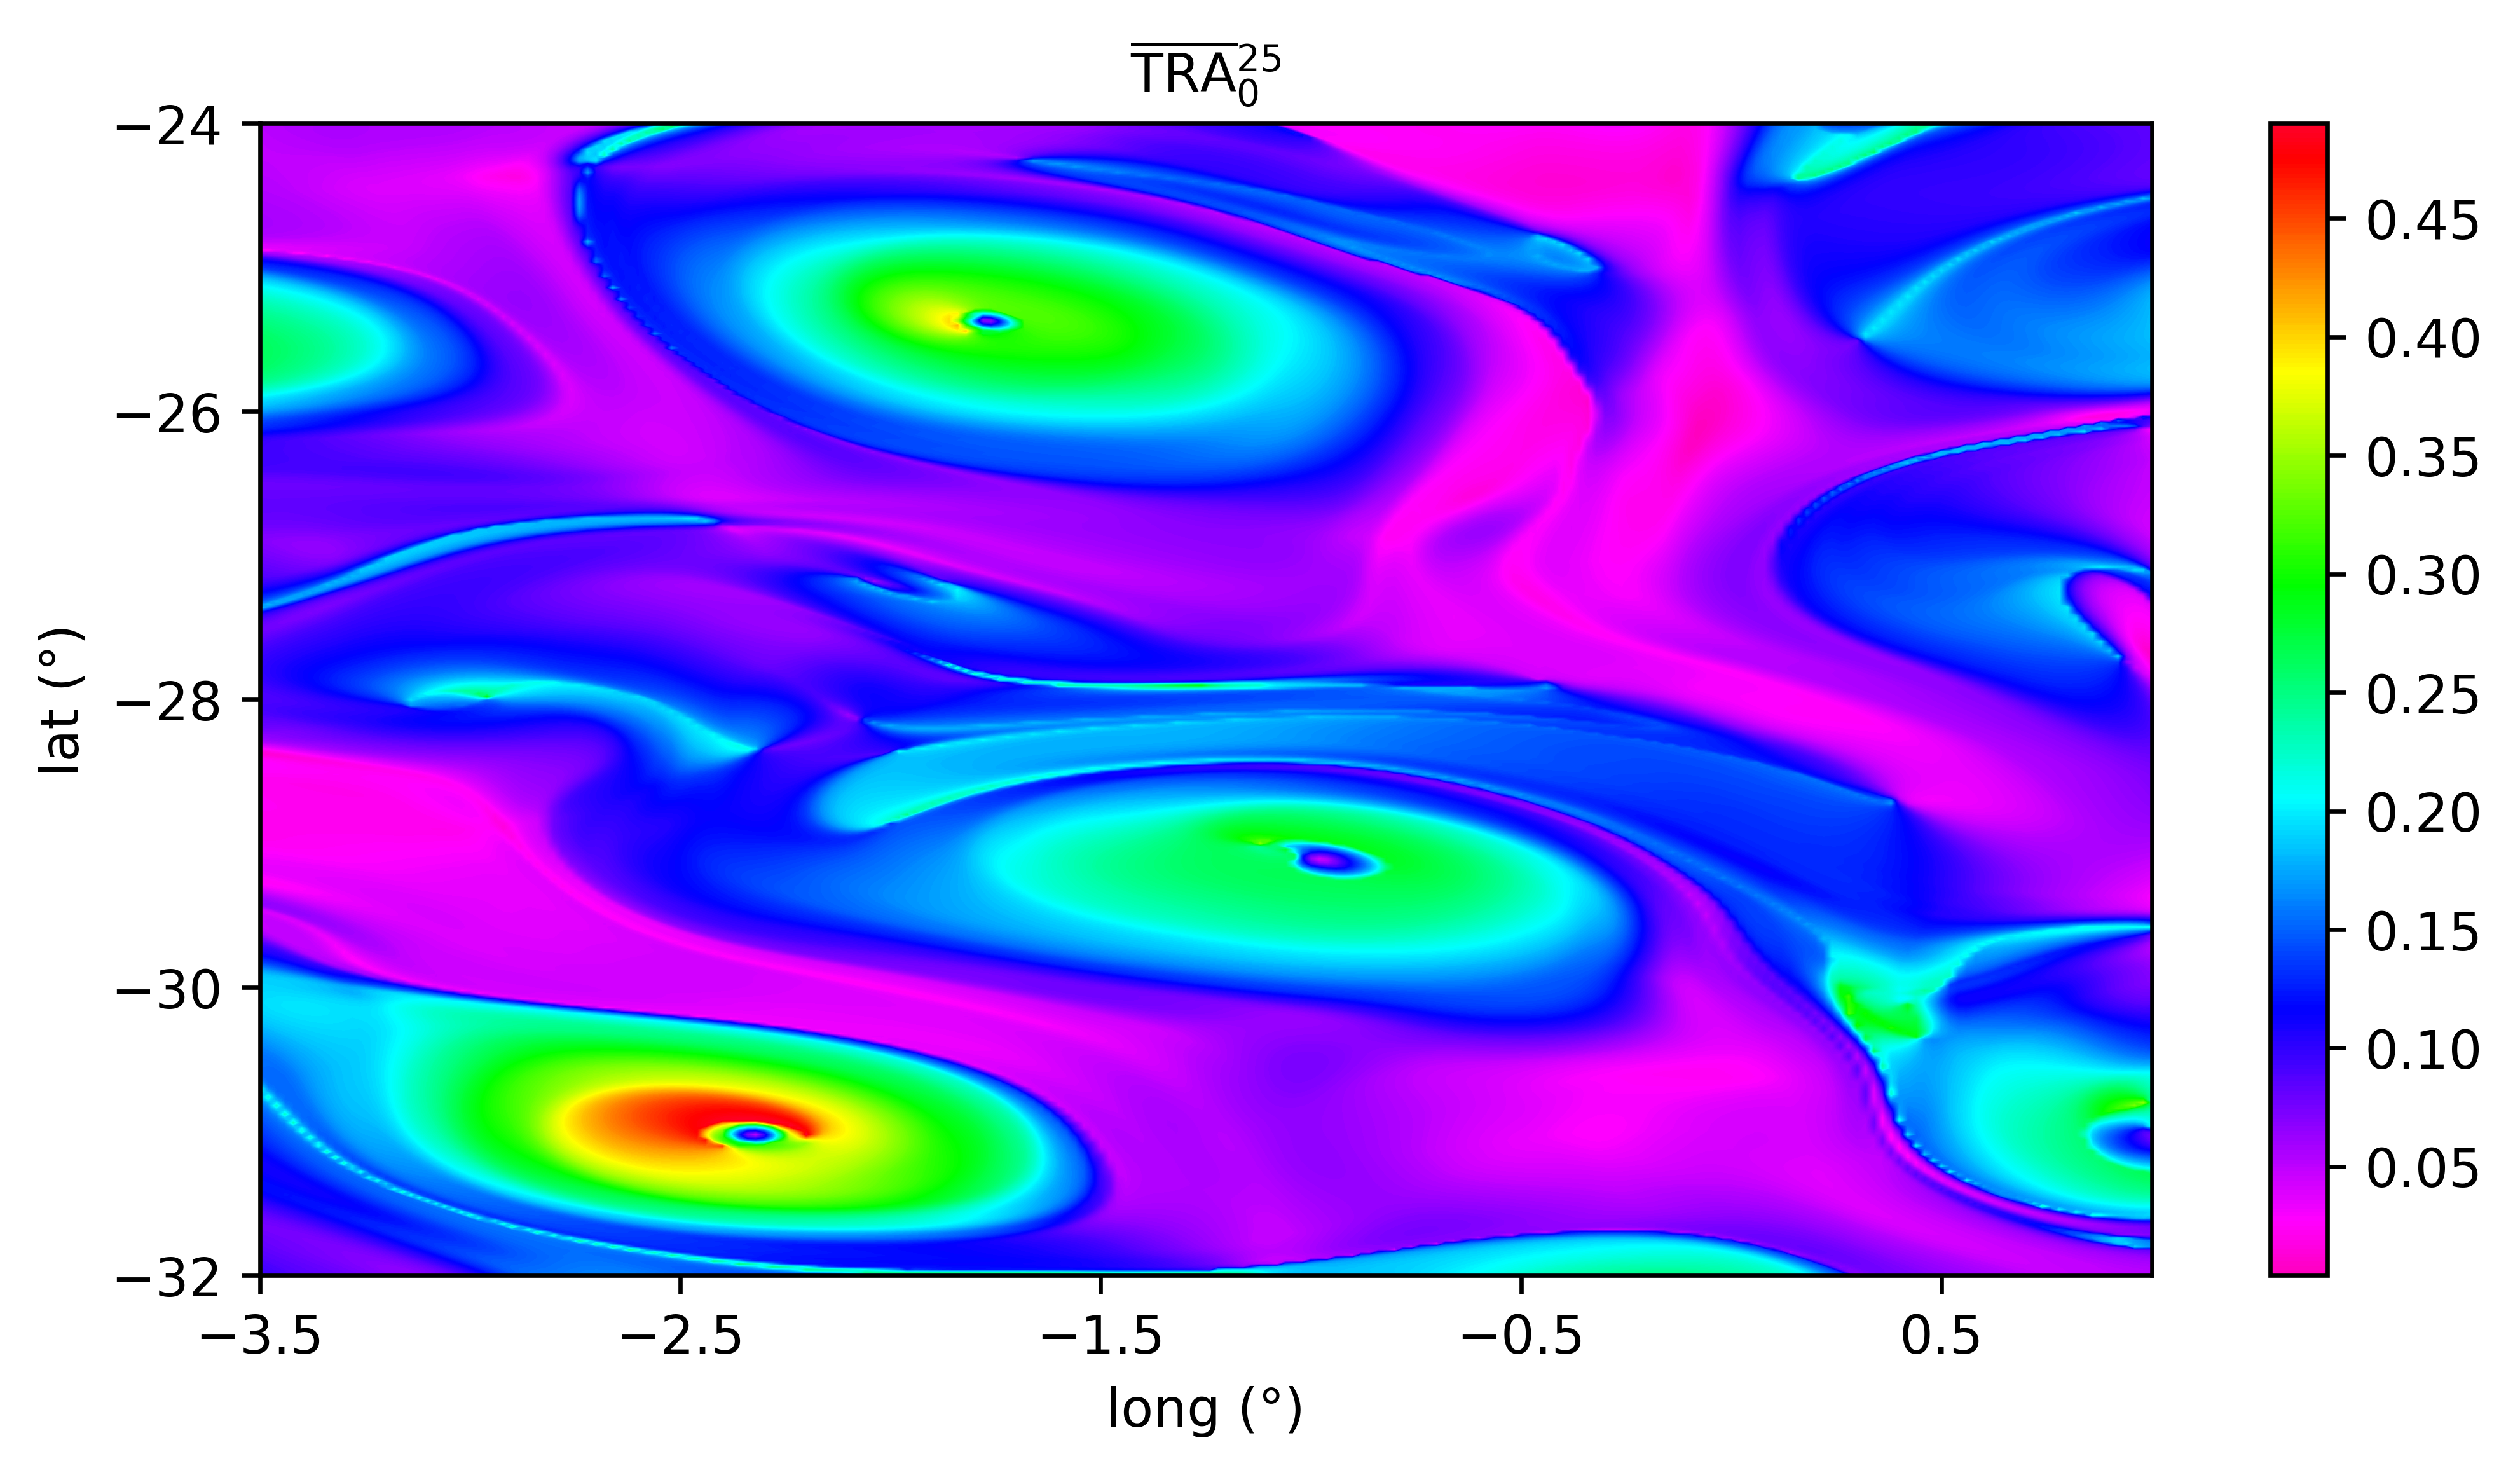

In [8]:
############################################ PLOT RESULTS ############################################
import matplotlib.pyplot as plt
import matplotlib.colors as colors

# Figure/Axis
fig = plt.figure(figsize=(8, 4), dpi = 600)
ax = plt.axes()

# Contourplot of TRA over meshgrid of initial conditions
cax = ax.contourf(X_domain, Y_domain, np.ma.masked_invalid(TRA), levels = 600, cmap = "gist_rainbow_r")

# Axis Labels
ax.set_xlabel("long (°)", fontsize = 10)
ax.set_ylabel("lat (°)", fontsize = 10)

# Ticks
ax.set_xticks(np.arange(xmin, xmax+0.1, 1))
ax.set_yticks(np.arange(ymin, ymax+0.1, 2))

# Colorbar
cbar = fig.colorbar(cax, ticks = np.arange(0, .5, .05))

# Title
ax.set_title(r'$ \mathrm{\overline{TRA}}$'+f'$_{{{int(time[0])}}}^{{{int(time[-1])}}}$', fontsize = 10)

plt.show()

Regions of high $ \mathrm{\overline{TRA}}_{t_0}^{t_N} $ are linked to vortical flow structures. Note that the $ \mathrm{\overline{TRA}} $ highlights the same vortical flow areas as other commonly used rotation diagnostics such as the [PRA](../../PRA2D/Main/PRAAgulhas.ipynb) or the [EllipticLCS](../../EllipticLCS/Main/EllipticLCSAgulhas.ipynb). In order to test the ability of the $ \mathrm{\overline{TRA}} $ to extract vortical flow regions even in a sparse data setting, we randomly progressively downsample the trajectory data. As shown in the following figures, $ \mathrm{\overline{TRA}} $ is able to capture the three major lagrangian eddies even at very low resolutions.

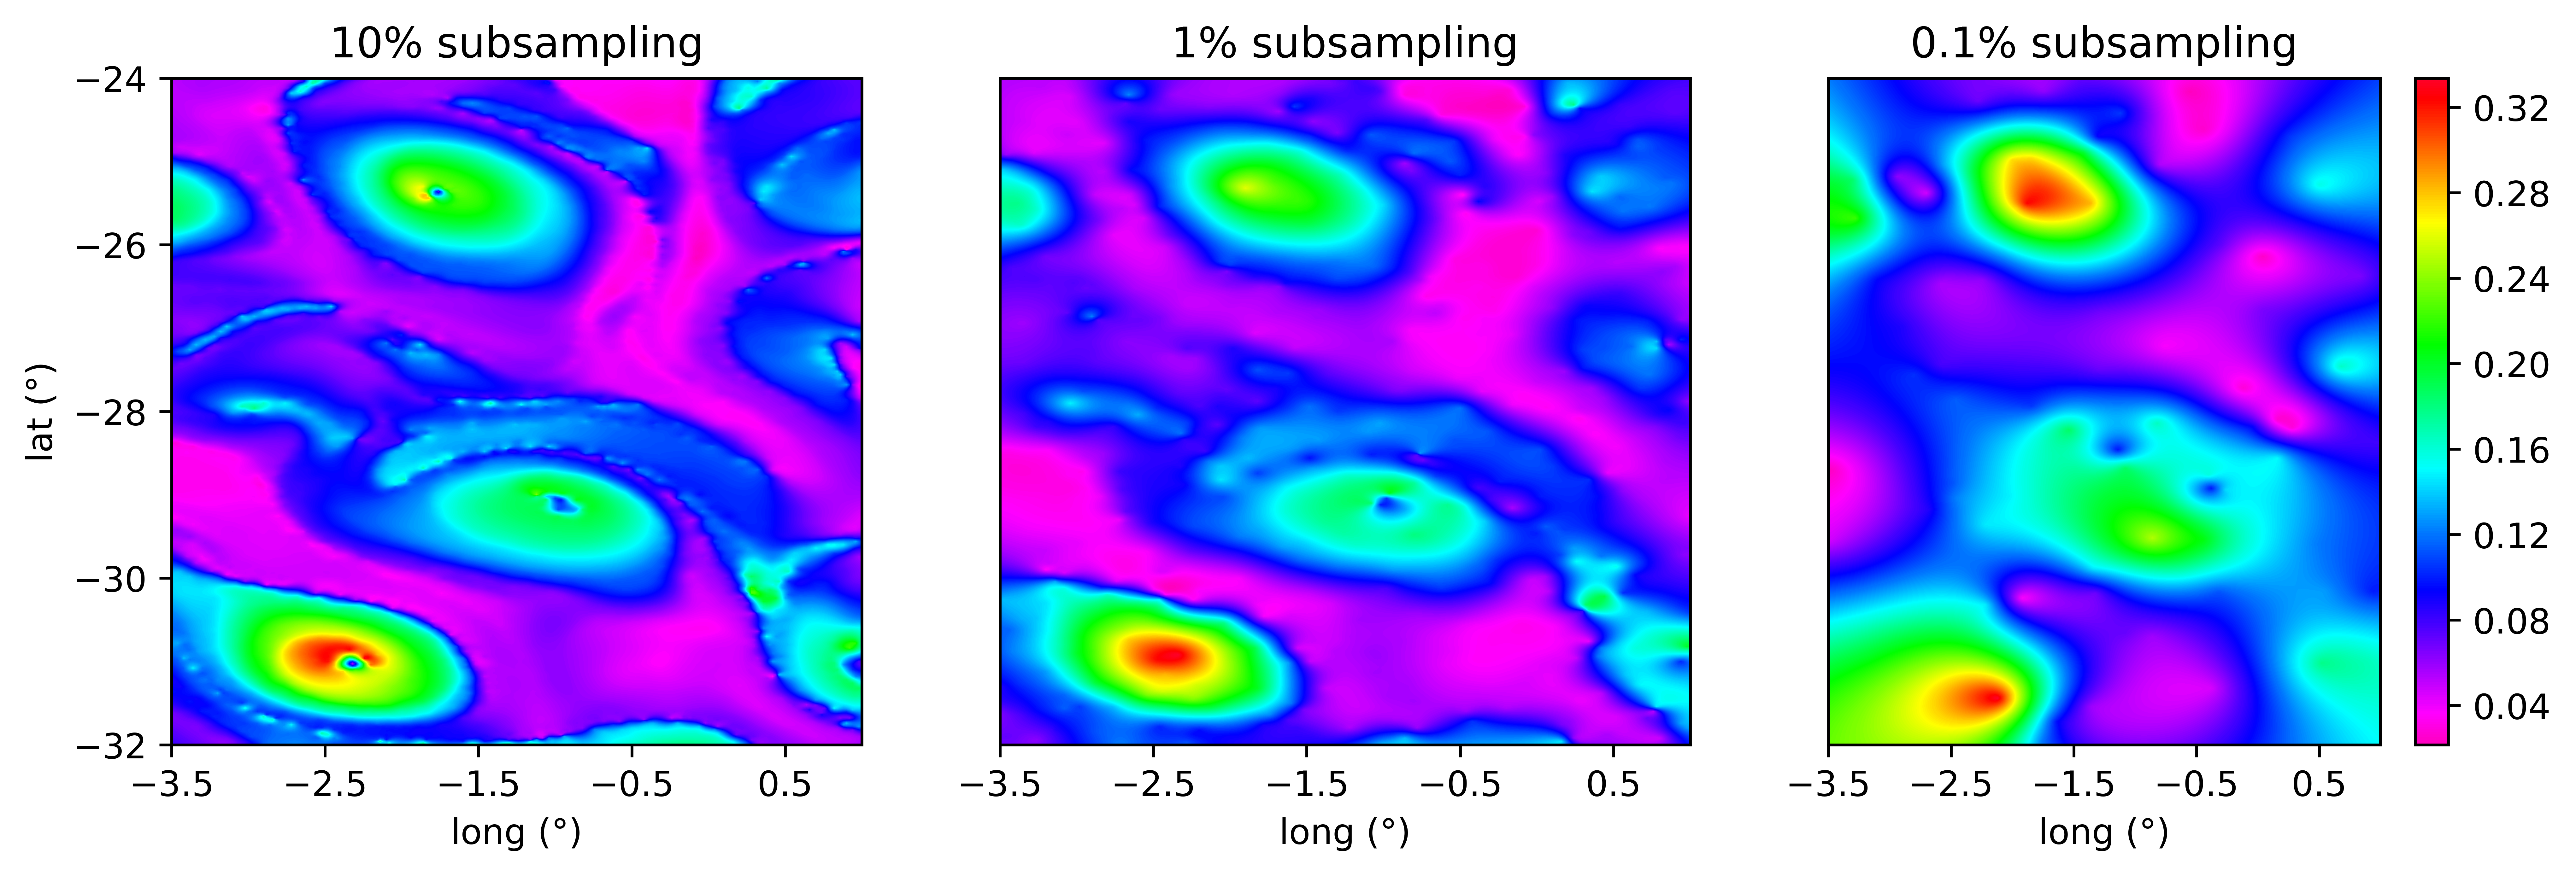

In [9]:
# import random number generator
import random

# 10% subsampling
rdn10 = random.sample(range(0, Nx*Ny), int(Nx*Ny/10))

# Subsample initial grid and TRA field (=subsample trajectories)
x_subsampled10 = X_domain.ravel()[rdn10] # array (Nx*Ny/10, )
y_subsampled10 = Y_domain.ravel()[rdn10] # array (Nx*Ny/10, )
TRA_subsampled10 = TRA.ravel()[rdn10] # array (Nx*Ny/10, )

# 1% subsampling
rdn100 = random.sample(range(0, Nx*Ny), int(Nx*Ny/100))

# Subsample initial grid and TRA field (=subsample trajectories)
x_subsampled100 = X_domain.ravel()[rdn100] # array (Nx*Ny/100, )
y_subsampled100 = Y_domain.ravel()[rdn100] # array (Nx*Ny/100, )
TRA_subsampled100 = TRA.ravel()[rdn100] # array (Nx*Ny/100, )

# 0.1% subsampling
rdn1000 = random.sample(range(0, Nx*Ny), int(Nx*Ny/1000))

# subsample initial grid and TRA field (=subsample trajectories)
x_subsampled1000 = X_domain.ravel()[rdn1000] # array (Nx*Ny/1000, )
y_subsampled1000 = Y_domain.ravel()[rdn1000] # array (Nx*Ny/1000, )
TRA_subsampled1000 = TRA.ravel()[rdn1000] # array (Nx*Ny/1000, )

# Import interpolant for scatter interpolation
from scipy.interpolate import Rbf

# Compute Interpolant
interp10 = Rbf(x_subsampled10, y_subsampled10, TRA_subsampled10, function = "linear")
interp100 = Rbf(x_subsampled100, y_subsampled100, TRA_subsampled100, function = "linear")
interp1000 = Rbf(x_subsampled1000, y_subsampled1000, TRA_subsampled1000, function = "linear")

# Re-evaluate interpolant over original (initial) meshgrid
TRA_interpolated10 = interp10(X_domain, Y_domain) 
TRA_interpolated100 = interp100(X_domain, Y_domain) 
TRA_interpolated1000 = interp1000(X_domain, Y_domain) 

# Figure/Axis
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, dpi = 800, figsize=(12, 3.5))

# Contourplot of TRA over meshgrid of initial conditions
cax = ax0.contourf(X_domain, Y_domain, np.ma.masked_invalid(TRA_interpolated10), cmap = "gist_rainbow_r", levels = 600)
cax = ax1.contourf(X_domain, Y_domain, np.ma.masked_invalid(TRA_interpolated100), cmap = "gist_rainbow_r", levels = 600)
cax = ax2.contourf(X_domain, Y_domain, np.ma.masked_invalid(TRA_interpolated1000), cmap = "gist_rainbow_r", levels = 600)

# Axis labels
ax0.set_xlabel("long (°)", fontsize = 10)
ax1.set_xlabel("long (°)", fontsize = 10)
ax2.set_xlabel("long (°)", fontsize = 10)
ax0.set_ylabel("lat (°)", fontsize = 10)

# Axis ticks
# Set axis ticks
ax0.set_xticks(np.arange(xmin, xmax+0.1, 1))
ax0.set_yticks(np.arange(ymin, ymax+0.1, 2))
ax1.set_xticks(np.arange(xmin, xmax+0.1, 1))
ax2.set_xticks(np.arange(xmin, xmax+0.1, 1))
ax1.set_yticks([])
ax2.set_yticks([])

ax0.set_title("10% subsampling")
ax1.set_title("1% subsampling")
ax2.set_title("0.1% subsampling")

# Colorbar
cbar = fig.colorbar(cax, ticks = np.linspace(0, 0.4, 11))

plt.show()

## Extract discrete vortex boundaries from $ \mathrm{\overline{TRA}}$

Finally we extract discrete eddy boundaries from the $ \mathrm{\overline{TRA}} $ using the algorithm proposed in [2]. The vortex boundaries are succesfully detected even under progressive downsampling.

In [10]:
# import function to compute vortex boundaries from TRA
from ipynb.fs.defs.extract_vortex import __extract_vortex__

# resolution of scattered interpolation
res_interpolation = 0.01

# threshold applied to local maxima in the TRA
TRA_loc = 0.25

# minimum number of drifters inside vortex
N_trajectories = 3

long_vortex10, lat_vortex10 = __extract_vortex__(X_domain.copy(), Y_domain.copy(), TRA_interpolated10, x_subsampled10, y_subsampled10, TRA_loc, N_trajectories)
long_vortex100, lat_vortex100 = __extract_vortex__(X_domain.copy(), Y_domain.copy(), TRA_interpolated100, x_subsampled100, y_subsampled100, TRA_loc, N_trajectories)
long_vortex1000, lat_vortex1000 = __extract_vortex__(X_domain.copy(), Y_domain.copy(), TRA_interpolated1000, x_subsampled1000, y_subsampled1000, TRA_loc, N_trajectories)

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

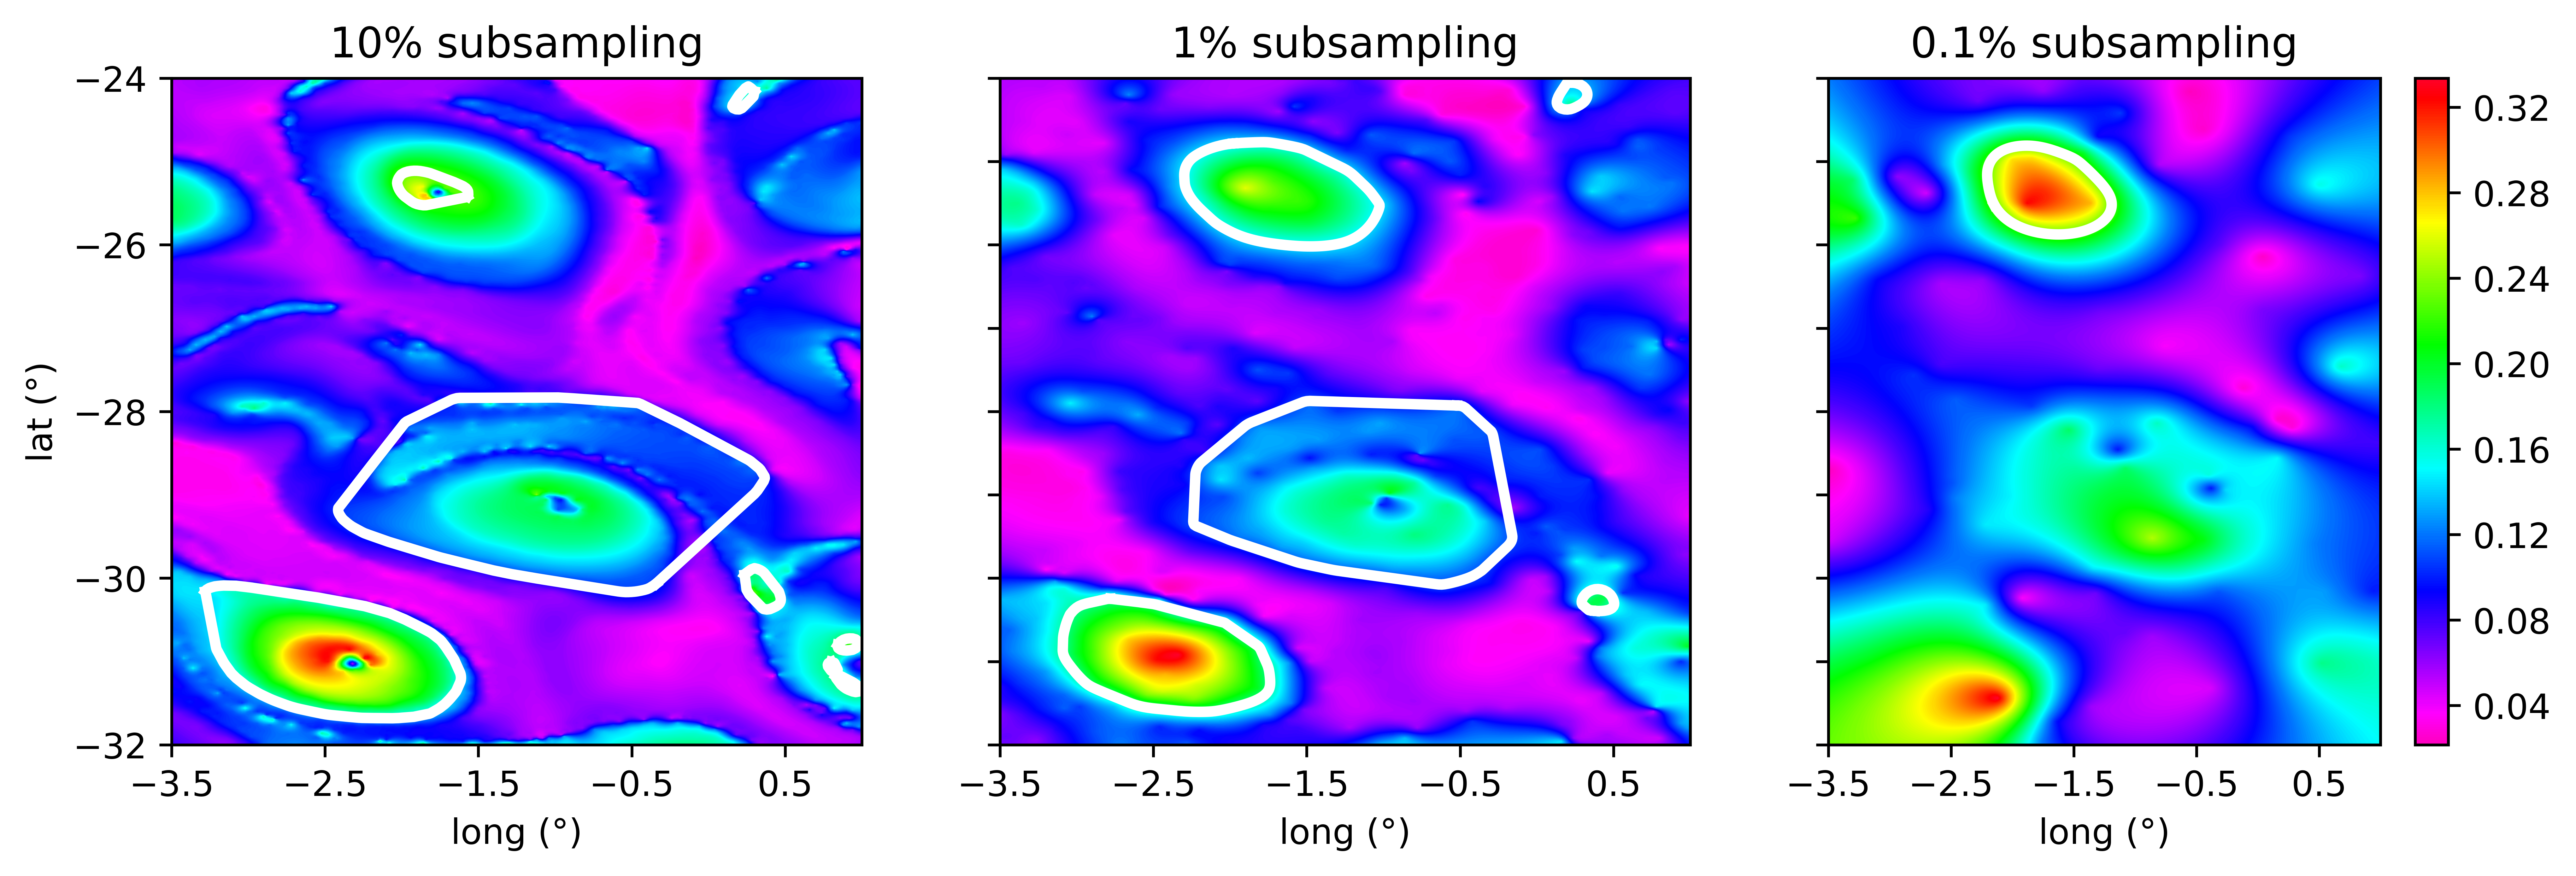

In [11]:
############################################ PLOT RESULTS ############################################
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, dpi = 800, figsize=(12, 3.5))

# Contourplot of TRA over meshgrid of initial conditions
cax = ax0.contourf(X_domain, Y_domain, np.ma.masked_invalid(TRA_interpolated10), cmap = "gist_rainbow_r", levels = 600)
cax = ax1.contourf(X_domain, Y_domain, np.ma.masked_invalid(TRA_interpolated100), cmap = "gist_rainbow_r", levels = 600)
cax = ax2.contourf(X_domain, Y_domain, np.ma.masked_invalid(TRA_interpolated1000), cmap = "gist_rainbow_r", levels = 600)

# iterate over all vortex boundaries identified in the region given by [x_min, x_max], [y_min, y_max]
for i in range(len(long_vortex10)):
    v_x = long_vortex10[i]
    v_y = lat_vortex10[i]
    ax0.plot(v_x, v_y, linewidth = 3, c = "w")
    
for i in range(len(long_vortex100)):
    v_x = long_vortex100[i]
    v_y = lat_vortex100[i]
    ax1.plot(v_x, v_y, linewidth = 3, c = "w")
    
for i in range(len(long_vortex1000)):
    v_x = long_vortex1000[i]
    v_y = lat_vortex1000[i]
    ax2.plot(v_x, v_y, linewidth = 3, c = "w")

# Axis labels
ax0.set_xlabel("long (°)", fontsize = 10)
ax1.set_xlabel("long (°)", fontsize = 10)
ax2.set_xlabel("long (°)", fontsize = 10)
ax0.set_ylabel("lat (°)", fontsize = 10)

# Axis ticks
# Set axis ticks
ax0.set_xticks(np.arange(xmin, xmax+0.1, 1))
ax0.set_yticks(np.arange(ymin, ymax+0.1, 2))
ax1.set_xticks(np.arange(xmin, xmax+0.1, 1))
ax2.set_xticks(np.arange(xmin, xmax+0.1, 1))
ax1.set_yticklabels([])
ax2.set_yticklabels([])

ax0.set_title("10% subsampling")
ax1.set_title("1% subsampling")
ax2.set_title("0.1% subsampling")

# Colorbar
cbar = fig.colorbar(cax, ticks = np.linspace(0, 0.4, 11))
#cbar.set_label(r'$(\dfrac{rad}{d})$', labelpad = -20, y=1.1, rotation = 0, fontsize = 6)

plt.show()

# References

[1] Haller, G., Aksamit, N., & Encinas-Bartos, A. P. (2021). Quasi-objective coherent structure diagnostics from single trajectories. Chaos: An Interdisciplinary Journal of Nonlinear Science, 31(4), 043131.

[2] Encinas-Bartos, A. P., Aksamit, N. O., & Haller, G. (2021). Quasi-Objective Eddy Visualization from Sparse Drifter Data. arXiv preprint.

[3] Notebook 5.5.3 in "Transport Barriers and Coherent Structures in Flow Data" by Prof. George Haller